# SKU Pricing Strategy Notebook

This notebook implements a pricing strategy with:
- **Single Price**: Hero SKUs match min market, others use median/max
- **Tier 1 Price**: Based on 50% quantity threshold, discount based on margin
- **Tier 2 Price**: Based on 75% quantity threshold, deeper discount based on margin

---

## Cell 1: Install Dependencies

In [1]:
%%capture

# Upgrade pip
!pip install --upgrade pip
# Connectivity
!pip install psycopg2-binary
!pip install snowflake-connector-python==3.15.0
!pip install snowflake-sqlalchemy
!pip install warnings
!pip install keyring==23.11.0
!pip install sqlalchemy==1.4.46
!pip install requests
!pip install boto3
!pip install oauth2client
!pip install gspread==5.9.0
!pip install gspread_dataframe
!pip install google.cloud
# Data manipulation and analysis
!pip install polars
!pip install pandas==2.2.1
!pip install numpy
!pip install openpyxl
!pip install xlsxwriter
# Date and time handling
!pip install --upgrade datetime
!pip install python-time
!pip install --upgrade pytz
# Progress bar
!pip install tqdm
# Database data types
!pip install db-dtypes
# Modeling
!pip install statsmodels
!pip install scikit-learn
!pip install import-ipynb
# Plotting
!pip install matplotlib
!pip install seaborn

## Cell 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import calendar
import json
from datetime import date, timedelta
from oauth2client.service_account import ServiceAccountCredentials
import importlib
import import_ipynb
import warnings
from datetime import datetime, timedelta
import pytz  
import os
import snowflake.connector
import boto3
warnings.filterwarnings("ignore")
import base64
from botocore.exceptions import ClientError
from requests import get
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully!")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/snowflake/connector/options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (22.0.0), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(


Libraries imported successfully!


## Cell 3: Setup Environment & Snowflake Connection

In [3]:
# Class to download from S3 bucket
class S3Downloader:
    def __init__(self, bucket_name):
        self.bucket_name = bucket_name

    def download_file(self, key, destination):
        """Download a file from S3 and ensure the local directory exists."""
        s3 = boto3.resource('s3')
        destination_dir = os.path.dirname(destination)
        if destination_dir:
            os.makedirs(destination_dir, exist_ok=True)
        try:
            s3.Bucket(self.bucket_name).download_file(key, destination)
            print(f"Downloaded: {key} -> {destination}")
        except ClientError as e:
            if e.response['Error']['Code'] == "404":
                print(f"Error: {key} does not exist in S3.")
            else:
                raise
        except FileNotFoundError as e:
            print(f"FileNotFoundError: {destination}. Ensure the path is correct.")
            raise e

# Initializing downloader class
downloader = S3Downloader('io.maxab.sagemaker1')

# Class downloads
dbdp_s3_path = 'automated-notebooks/amrmaali/DBDP_Revamped'
downloader.download_file(f'{dbdp_s3_path}/setup_environment_2.py', 'setup_environment_2.py')

# Class imports
import setup_environment_2
importlib.reload(setup_environment_2)
setup_environment_2.initialize_env()

print("Environment setup complete!")

Downloaded: automated-notebooks/amrmaali/DBDP_Revamped/setup_environment_2.py -> setup_environment_2.py
/home/ec2-user/.Renviron
/home/ec2-user/service_account_key.json
Environment setup complete!


## Cell 4: Define Snowflake Query Function

In [4]:
def query_snowflake(query, columns=[]):
    """Execute a query on Snowflake and return results as DataFrame"""
    con = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USERNAME"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        database=os.environ["SNOWFLAKE_DATABASE"]
    )
    try:
        cur = con.cursor()
        cur.execute("USE WAREHOUSE COMPUTE_WH")
        cur.execute(query)
        if len(columns) == 0:
            out = pd.DataFrame(np.array(cur.fetchall()))
        else:
            out = pd.DataFrame(np.array(cur.fetchall()), columns=columns)
        return out
    except Exception as e:
        print("Error: ", e)
    finally:
        cur.close()
        con.close()

print("Snowflake query function defined.")

Snowflake query function defined.


## Cell 5: Load Base SKU Data with Prices, WAC, and Market Data

In [5]:
# Main query to get SKU base data with prices, WAC, and market data
sku_base_query = '''
WITH whs AS (
    SELECT *
    FROM (VALUES
        ('Cairo', 'El-Marg', 38, 700),
        ('Cairo', 'Mostorod', 1, 700),
        ('Giza', 'Barageel', 236, 701),
        ('Giza', 'Basatin', 39, 701),
        ('Delta West', 'El-Mahala', 337, 703),
        ('Delta West', 'Tanta', 8, 703),
        ('Delta East', 'Mansoura FC', 339, 704),
        ('Delta East', 'Sharqya', 170, 704),
        ('Upper Egypt', 'Assiut FC', 501, 1124),
        ('Upper Egypt', 'Bani sweif', 401, 1126),
        ('Upper Egypt', 'Menya Samalot', 703, 1123),
        ('Upper Egypt', 'Sohag', 632, 1125),
        ('Alexandria', 'Khorshed Alex', 797, 702),
        ('Giza', 'Sakkarah', 962, 701)
    ) x(region, wh, warehouse_id, cohort_id)
),

stocks AS (
    SELECT cohort_id, product_id, SUM(stocks) AS stocks 
    FROM (
        SELECT DISTINCT whs.region,
            cohort_id,	
            whs.wh,
            product_warehouse.product_id,
            (product_warehouse.available_stock)::integer AS stocks
        FROM whs
        JOIN product_warehouse ON product_warehouse.warehouse_id = whs.warehouse_id
        JOIN products ON product_warehouse.product_id = products.id
        JOIN product_units ON products.unit_id = product_units.id
        WHERE product_warehouse.warehouse_id NOT IN (6,9,10)
            AND product_warehouse.is_basic_unit = 1
            AND product_warehouse.available_stock > 0 
    )
    GROUP BY ALL
),

base AS (
    SELECT *, ROW_NUMBER() OVER(PARTITION BY retailer_id ORDER BY priority) AS rnk 
    FROM (
        SELECT x.*, TAGGABLE_ID AS retailer_id 
        FROM (
            SELECT id AS cohort_id, name AS cohort_name, priority, dynamic_tag_id 
            FROM cohorts 
            WHERE is_active = 'true'
            AND id IN (700, 701, 702, 703, 704, 1123, 1124, 1125, 1126)
        ) x 
        JOIN DYNAMIC_TAGGABLES dt ON x.dynamic_tag_id = dt.dynamic_tag_id
    )
    QUALIFY rnk = 1 
    ORDER BY cohort_id
),

-- Step 1: Get raw order counts
order_counts_raw AS (
    SELECT 
        base.cohort_id,
        pso.product_id,
        pso.packing_unit_id,
        COUNT(DISTINCT parent_sales_order_id) AS order_count,
        SUM(pso.total_price) AS nmv
    FROM product_sales_order pso
    JOIN sales_orders so ON so.id = pso.sales_order_id
    JOIN base ON base.retailer_id = so.retailer_id
    JOIN products ON products.id = pso.product_id
    WHERE so.created_at::date BETWEEN DATE_TRUNC('month', CURRENT_DATE - INTERVAL '2 months') AND CURRENT_DATE - 1
        AND so.sales_order_status_id NOT IN (7, 12)
        AND so.channel IN ('telesales', 'retailer')
        AND pso.purchased_item_count <> 0
    GROUP BY base.cohort_id, pso.product_id, pso.packing_unit_id
),

-- Step 2: Calculate cohort totals separately
cohort_totals AS (
    SELECT 
        cohort_id,
        SUM(order_count) AS total_orders_cohort
    FROM order_counts_raw
    GROUP BY cohort_id
),

-- Step 3: Calculate contribution and cumulative
order_contribution AS (
    SELECT 
        ocr.cohort_id,
        ocr.product_id,
        ocr.packing_unit_id,
        ocr.order_count,
        ocr.nmv,
        ct.total_orders_cohort,
        ocr.order_count / ct.total_orders_cohort AS order_contribution,
        SUM(ocr.order_count / ct.total_orders_cohort) 
            OVER(PARTITION BY ocr.cohort_id ORDER BY ocr.order_count DESC ROWS UNBOUNDED PRECEDING) AS cumulative_contribution
    FROM order_counts_raw ocr
    JOIN cohort_totals ct ON ct.cohort_id = ocr.cohort_id
),

-- Get current prices by cohort
prices AS (
    SELECT 
        CASE 
            WHEN cpu.cohort_id IN (700, 695) THEN 'Cairo'
            WHEN cpu.cohort_id IN (701) THEN 'Giza'
            WHEN cpu.cohort_id IN (704, 698) THEN 'Delta East'
            WHEN cpu.cohort_id IN (703, 697) THEN 'Delta West'
            WHEN cpu.cohort_id IN (696, 1123, 1124, 1125, 1126) THEN 'Upper Egypt'
            WHEN cpu.cohort_id IN (702, 699) THEN 'Alexandria'
        END AS region,
        cohort_id,
        pu.product_id,
        pu.packing_unit_id,
        pu.basic_unit_count,
        AVG(cpu.price) AS price
    FROM cohort_product_packing_units cpu
    JOIN PACKING_UNIT_PRODUCTS pu ON pu.id = cpu.product_packing_unit_id
    WHERE cpu.cohort_id IN (700, 701, 702, 703, 704, 696, 695, 698, 697, 699, 1123, 1124, 1125, 1126)
        AND cpu.created_at::date <> '2023-07-31'
        AND cpu.is_customized = true
    GROUP BY ALL
),

-- Get market prices (competitor prices)
market_prices AS (
    SELECT 
        product_id,
        region,
        MIN(market_price) AS min_market_price,
        MAX(market_price) AS max_market_price,
        MEDIAN(market_price) AS median_market_price
    FROM materialized_views.cleaned_market_prices
    WHERE date::date >= CURRENT_DATE - 7
    GROUP BY product_id, region
),

-- Get WAC (weighted average cost)
wac AS (
    SELECT 
        product_id, 
        wac1,
        wac4, 
        wac_p
    FROM finance.all_cogs
    WHERE CURRENT_TIMESTAMP BETWEEN from_date AND to_date
)

SELECT DISTINCT
    oc.cohort_id,
    b.cohort_name,
    p.region,
    oc.product_id,
    CONCAT(products.name_ar, ' ', products.size, ' ', product_units.name_ar) AS sku,
    brands.name_ar AS brand,
    categories.name_ar AS cat,
    oc.packing_unit_id,
    p.basic_unit_count,
    oc.order_count,
    oc.nmv,
    oc.order_contribution,
    oc.cumulative_contribution,
    p.price AS current_price,
    mp.min_market_price,
    mp.median_market_price,
    mp.max_market_price,
    w.wac1,
    w.wac4,
    w.wac_p,
    s.stocks
FROM order_contribution oc
JOIN (
    SELECT DISTINCT cohort_id, cohort_name FROM base
) b ON b.cohort_id = oc.cohort_id
LEFT JOIN prices p ON p.cohort_id = oc.cohort_id 
    AND p.product_id = oc.product_id 
    AND p.packing_unit_id = oc.packing_unit_id
LEFT JOIN market_prices mp ON mp.product_id = oc.product_id AND mp.region = p.region
LEFT JOIN wac w ON w.product_id = oc.product_id
LEFT JOIN stocks s ON s.product_id = oc.product_id AND s.cohort_id = oc.cohort_id
JOIN products ON products.id = oc.product_id
JOIN brands ON products.brand_id = brands.id
JOIN categories ON products.category_id = categories.id
JOIN product_units ON product_units.id = products.unit_id
WHERE products.activation = true
    AND categories.name_ar NOT LIKE '%سايب%'
    AND categories.name_ar NOT IN ('كروت شحن', 'مياه معدنيه', 'مقرمشات', 'شيبسي')
    AND brands.name_ar NOT IN ('فيوري')
ORDER BY oc.cohort_id, oc.order_count DESC
'''

print("Executing SKU base query...")
df_skus = query_snowflake(sku_base_query, columns=[
    'cohort_id', 'cohort_name', 'region', 'product_id', 'sku', 'brand', 'cat',
    'packing_unit_id', 'basic_unit_count', 'order_count', 'nmv', 'order_contribution',
    'cumulative_contribution', 'current_price', 'min_market_price', 'median_market_price',
    'max_market_price', 'wac1', 'wac4', 'wac_p', 'stocks'
])

# Check if query returned data
if df_skus is None or len(df_skus) == 0:
    print("ERROR: Query returned no data!")
else:
    # Convert numeric columns
    numeric_cols = ['cohort_id', 'product_id', 'packing_unit_id', 'basic_unit_count', 'order_count', 
                    'nmv', 'order_contribution', 'cumulative_contribution', 'current_price',
                    'min_market_price', 'median_market_price', 'max_market_price', 'wac1', 'wac4', 'wac_p', 'stocks']
    for col in numeric_cols:
        df_skus[col] = pd.to_numeric(df_skus[col], errors='coerce')

    print(f"Loaded {len(df_skus)} SKU records")
    display(df_skus.head(10))

Executing SKU base query...
Loaded 25213 SKU records


,cohort_id,cohort_name,region,product_id,sku,brand,cat,packing_unit_id,basic_unit_count,order_count,nmv,order_contribution,cumulative_contribution,current_price,min_market_price,median_market_price,max_market_price,wac1,wac4,wac_p,stocks
0,700,Pricing_Model_Cairo_V2,Cairo,305,عصير بيتى مانجو - 235 مل,بيتي عصاير,عصاير,2,1.00,11393,5647755.51,0.01,0.01,204.75,NaN,NaN,NaN,203.34,185.60,185.60,1992.00
1,700,Pricing_Model_Cairo_V2,Cairo,8672,ماكسى كولا - 400 مل,ماكسى,حاجه ساقعه,2,1.00,10727,4838469.00,0.01,0.02,102.50,NaN,NaN,NaN,96.00,96.00,96.00,1.00
2,700,Pricing_Model_Cairo_V2,Cairo,326,بيبسى كانز ستار - 320 مل,بيبسي,حاجه ساقعه,2,1.00,10347,12360820.14,0.01,0.02,313.75,314.00,321.00,341.25,310.35,302.33,302.33,8.00
3,700,Pricing_Model_Cairo_V2,Cairo,130,لبن بخيره - 500 مل,بخيره,ألبان,1,1.00,9381,9678697.12,0.01,0.03,491.50,NaN,NaN,NaN,503.77,475.59,475.59,70.00
4,700,Pricing_Model_Cairo_V2,Cairo,3,ارز حبوبة رفيع - 1 كجم,حبوبة,أرز,2,1.00,9056,6738010.50,0.01,0.04,241.50,236.00,257.00,266.00,235.96,231.24,231.24,2464.00
5,700,Pricing_Model_Cairo_V2,Cairo,2049,كوفى بريك 2*1 - 11 جم,كوفي بريك,قهوة,3,1.00,9037,2742778.53,0.01,0.05,53.25,NaN,NaN,NaN,58.79,51.68,51.68,1924.00
6,700,Pricing_Model_Cairo_V2,Cairo,205,لبن جهينة مكس شوكولاتة - 200 مل,جهينة ألبان,ألبان,2,1.00,8980,4241814.62,0.01,0.05,267.25,258.58,275.00,277.00,276.09,256.76,256.76,906.00
7,700,Pricing_Model_Cairo_V2,Cairo,6935,كوكاكولا اكشن - 300 مل,كوكا كولا,حاجه ساقعه,2,1.00,8803,6080543.58,0.01,0.07,103.00,104.50,110.00,115.95,107.00,93.00,93.00,5283.00
8,700,Pricing_Model_Cairo_V2,Cairo,144,عصير بيتى كوكتيل - 235 مل,بيتي عصاير,عصاير,2,1.00,8294,3140121.16,0.01,0.07,198.00,NaN,NaN,NaN,194.83,177.71,177.71,1001.00
9,700,Pricing_Model_Cairo_V2,Cairo,143,عصير بيتى تفاح - 235 مل,بيتي عصاير,عصاير,2,1.00,8052,3520775.93,0.01,0.08,198.00,NaN,NaN,NaN,201.12,184.35,184.35,360.00


## Cell 6: Identify Hero SKUs

Hero SKUs are defined as the top SKUs that contribute to 80% of orders (cumulative contribution)

In [6]:
# Define Hero SKU threshold (top 80% of order contribution)
HERO_THRESHOLD = 0.4

# Flag hero SKUs based on cumulative contribution
df_skus['is_hero'] = df_skus['cumulative_contribution'] <= HERO_THRESHOLD

# Summary statistics by cohort
hero_summary = df_skus.groupby('cohort_id').agg({
    'is_hero': ['sum', 'count'],
    'product_id': 'nunique'
}).reset_index()
hero_summary.columns = ['cohort_id', 'hero_count', 'total_skus', 'unique_products']
hero_summary['hero_pct'] = hero_summary['hero_count'] / hero_summary['total_skus'] * 100

print(f"\n{'='*50}")
print(f"HERO SKU IDENTIFICATION RESULTS")
print(f"{'='*50}")
print(f"\nTotal SKUs: {len(df_skus)}")
print(f"Hero SKUs: {df_skus['is_hero'].sum()} ({df_skus['is_hero'].mean()*100:.1f}%)")
print(f"Non-Hero SKUs: {(~df_skus['is_hero']).sum()} ({(~df_skus['is_hero']).mean()*100:.1f}%)")
print(f"\nHero SKUs contribute to {HERO_THRESHOLD*100:.0f}% of total orders")

print("\nHero Summary by Cohort:")
print(hero_summary.to_string(index=False))

df_skus[['cohort_id', 'region', 'product_id', 'sku', 'order_count', 'order_contribution', 'cumulative_contribution', 'is_hero']].head(20)


HERO SKU IDENTIFICATION RESULTS

Total SKUs: 25213
Hero SKUs: 761 (3.0%)
Non-Hero SKUs: 24452 (97.0%)

Hero SKUs contribute to 40% of total orders

Hero Summary by Cohort:
 cohort_id  hero_count  total_skus  unique_products  hero_pct
       700         128        4294             3071      2.98
       701         146        4175             3021      3.50
       702          75        2722             2161      2.76
       703          92        3280             2478      2.80
       704         104        3184             2376      3.27
      1123          55        2039             1555      2.70
      1124          55        1870             1465      2.94
      1125          51        1748             1364      2.92
      1126          55        1901             1473      2.89


,cohort_id,region,product_id,sku,order_count,order_contribution,cumulative_contribution,is_hero
0,700,Cairo,305,عصير بيتى مانجو - 235 مل,11393,0.01,0.01,True
1,700,Cairo,8672,ماكسى كولا - 400 مل,10727,0.01,0.02,True
2,700,Cairo,326,بيبسى كانز ستار - 320 مل,10347,0.01,0.02,True
3,700,Cairo,130,لبن بخيره - 500 مل,9381,0.01,0.03,True
4,700,Cairo,3,ارز حبوبة رفيع - 1 كجم,9056,0.01,0.04,True
5,700,Cairo,2049,كوفى بريك 2*1 - 11 جم,9037,0.01,0.05,True
6,700,Cairo,205,لبن جهينة مكس شوكولاتة - 200 مل,8980,0.01,0.05,True
7,700,Cairo,6935,كوكاكولا اكشن - 300 مل,8803,0.01,0.07,True
8,700,Cairo,144,عصير بيتى كوكتيل - 235 مل,8294,0.01,0.07,True
9,700,Cairo,143,عصير بيتى تفاح - 235 مل,8052,0.01,0.08,True


## Cell 7: Determine Single Price

Pricing Logic:
- **Hero SKUs**: Match the MINIMUM market price (competitive positioning)
- **Non-Hero SKUs**: Use MEDIAN or MAX market price (margin optimization)

In [7]:
def determine_single_price(df):
    """
    Determine single price based on hero status:
    - Hero SKUs: min market price
    - Non-Hero SKUs: median market price
    If market price is not available, use current price
    Uses WAC4 (back margin) for margin calculations
    """
    df = df.copy()
    
    # Calculate single price based on hero status
    df['single_price'] = np.where(
        df['is_hero'],
        df['min_market_price'].fillna(df['current_price']),  # Hero: match min market
        df['median_market_price'].fillna(df['current_price'])  # Non-hero: use median
    )
    
    # Fill any remaining NaN with current price
    df['single_price'] = df['single_price'].fillna(df['current_price'])
    
    # Calculate cost per packing unit using WAC4 (BACK MARGIN)
    df['cost_per_pu'] = df['wac4'] * df['basic_unit_count']
    
    # Also keep front cost for reference
    df['cost_per_pu_front'] = df['wac1'] * df['basic_unit_count']
    
    # Calculate margin at single price (using BACK MARGIN)
    df['single_price_margin'] = (df['single_price'] - df['cost_per_pu']) / df['single_price']
    
    # Also calculate front margin for reference
    df['single_price_front_margin'] = (df['single_price'] - df['cost_per_pu_front']) / df['single_price']
    
    # Flag if price is below cost (WAC4)
    df['single_price_below_cost'] = df['single_price'] < df['cost_per_pu']
    
    # Pricing source indicator
    df['price_source'] = np.where(df['is_hero'], 'Min Market (Hero)', 'Median Market')
    
    return df

# Apply single price determination
df_skus = determine_single_price(df_skus)

# Summary
print(f"\n{'='*50}")
print(f"SINGLE PRICE DETERMINATION RESULTS (USING BACK MARGIN)")
print(f"{'='*50}")

# Hero vs Non-Hero pricing summary
print(f"\nHero SKUs Pricing:")
print(f"  Average Single Price: {df_skus[df_skus['is_hero']]['single_price'].mean():.2f}")
print(f"  Average Back Margin: {df_skus[df_skus['is_hero']]['single_price_margin'].mean()*100:.1f}%")
print(f"  Average Front Margin: {df_skus[df_skus['is_hero']]['single_price_front_margin'].mean()*100:.1f}%")

print(f"\nNon-Hero SKUs Pricing:")
print(f"  Average Single Price: {df_skus[~df_skus['is_hero']]['single_price'].mean():.2f}")
print(f"  Average Back Margin: {df_skus[~df_skus['is_hero']]['single_price_margin'].mean()*100:.1f}%")
print(f"  Average Front Margin: {df_skus[~df_skus['is_hero']]['single_price_front_margin'].mean()*100:.1f}%")

# Below cost warning
below_cost_count = df_skus['single_price_below_cost'].sum()
if below_cost_count > 0:
    print(f"\n⚠️ WARNING: {below_cost_count} SKUs have single price below WAC4 (back cost)!")

df_skus[['cohort_id', 'product_id', 'sku', 'is_hero', 'min_market_price', 'median_market_price', 
         'current_price', 'single_price', 'price_source', 'cost_per_pu', 'single_price_margin', 'single_price_front_margin']].head(15)


SINGLE PRICE DETERMINATION RESULTS (USING BACK MARGIN)

Hero SKUs Pricing:
  Average Single Price: 222.91
  Average Back Margin: 2.8%
  Average Front Margin: -3.9%

Non-Hero SKUs Pricing:
  Average Single Price: 368.06
  Average Back Margin: -39.4%
  Average Front Margin: -47.7%

⚠️ WARNING: 1619 SKUs have single price below WAC4 (back cost)!


,cohort_id,product_id,sku,is_hero,min_market_price,median_market_price,current_price,single_price,price_source,cost_per_pu,single_price_margin,single_price_front_margin
0,700,305,عصير بيتى مانجو - 235 مل,True,NaN,NaN,204.75,204.75,Min Market (Hero),185.60,0.09,0.01
1,700,8672,ماكسى كولا - 400 مل,True,NaN,NaN,102.50,102.50,Min Market (Hero),96.00,0.06,0.06
2,700,326,بيبسى كانز ستار - 320 مل,True,314.00,321.00,313.75,314.00,Min Market (Hero),302.33,0.04,0.01
3,700,130,لبن بخيره - 500 مل,True,NaN,NaN,491.50,491.50,Min Market (Hero),475.59,0.03,-0.02
4,700,3,ارز حبوبة رفيع - 1 كجم,True,236.00,257.00,241.50,236.00,Min Market (Hero),231.24,0.02,0.00
5,700,2049,كوفى بريك 2*1 - 11 جم,True,NaN,NaN,53.25,53.25,Min Market (Hero),51.68,0.03,-0.10
6,700,205,لبن جهينة مكس شوكولاتة - 200 مل,True,258.58,275.00,267.25,258.58,Min Market (Hero),256.76,0.01,-0.07
7,700,6935,كوكاكولا اكشن - 300 مل,True,104.50,110.00,103.00,104.50,Min Market (Hero),93.00,0.11,-0.02
8,700,144,عصير بيتى كوكتيل - 235 مل,True,NaN,NaN,198.00,198.00,Min Market (Hero),177.71,0.10,0.02
9,700,143,عصير بيتى تفاح - 235 مل,True,NaN,NaN,198.00,198.00,Min Market (Hero),184.35,0.07,-0.02


## Cell 8: Load Quantity Distribution Data

In [8]:
# Query to get quantity distribution per SKU by cohort
quantity_query = '''
WITH base AS (
    SELECT *, ROW_NUMBER() OVER(PARTITION BY retailer_id ORDER BY priority) AS rnk 
    FROM (
        SELECT x.*, TAGGABLE_ID AS retailer_id 
        FROM (
            SELECT id AS cohort_id, name AS cohort_name, priority, dynamic_tag_id 
            FROM cohorts 
            WHERE is_active = 'true'
            AND id IN (700, 701, 702, 703, 704, 1123, 1124, 1125, 1126)
        ) x 
        JOIN DYNAMIC_TAGGABLES dt ON x.dynamic_tag_id = dt.dynamic_tag_id
    )
    QUALIFY rnk = 1 
)

SELECT 
    cohort_id,
    product_id,
    packing_unit_id,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY qty) AS median_qty,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY qty) AS q75_qty,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY qty) AS q90_qty,
    AVG(qty) AS avg_qty,
    STDDEV(qty) AS std_qty,
    COUNT(DISTINCT retailer_id) AS unique_retailers
FROM (
    SELECT DISTINCT
        base.cohort_id,
        so.retailer_id,
        pso.product_id,
        packing_unit_id,
        SUM(pso.purchased_item_count) AS qty
    FROM product_sales_order pso
    JOIN sales_orders so ON so.id = pso.sales_order_id
    JOIN base ON base.retailer_id = so.retailer_id
    WHERE so.created_at::date BETWEEN DATE_TRUNC('month', CURRENT_DATE - INTERVAL '2 months') AND CURRENT_DATE - 1
        AND so.sales_order_status_id NOT IN (7, 12)
        AND so.channel IN ('telesales', 'retailer')
        AND pso.purchased_item_count > 0
    GROUP BY ALL
)
GROUP BY cohort_id, product_id, packing_unit_id
'''

print("Executing quantity distribution query...")
df_quantities = query_snowflake(quantity_query, columns=[
    'cohort_id', 'product_id', 'packing_unit_id', 'median_qty', 'q75_qty', 'q90_qty', 'avg_qty', 'std_qty', 'unique_retailers'
])

# Convert numeric columns
for col in df_quantities.columns:
    df_quantities[col] = pd.to_numeric(df_quantities[col], errors='coerce')

print(f"Loaded quantity distribution data: {len(df_quantities)} records")
df_quantities.head(10)

Executing quantity distribution query...
Loaded quantity distribution data: 26947 records


,cohort_id,product_id,packing_unit_id,median_qty,q75_qty,q90_qty,avg_qty,std_qty,unique_retailers
0,700,21689,3,2.00,4.00,6.80,3.22,2.47,63
1,701,11254,7,2.00,4.00,6.60,3.21,2.60,38
2,700,9480,1,1.00,1.00,1.00,1.00,0.00,4
3,1125,3598,15,1.00,3.00,4.80,2.40,2.19,5
4,703,1409,11,3.00,3.00,3.00,3.00,NaN,1
5,703,12265,1,2.00,2.00,2.00,2.00,NaN,1
6,704,22363,1,1.00,3.00,3.00,1.75,0.97,12
7,704,12265,1,1.00,1.00,1.00,1.00,NaN,1
8,704,2662,1,1.00,1.00,1.60,1.33,1.00,9
9,700,6055,3,2.00,3.00,5.00,2.67,2.83,189


## Cell 9: Calculate Tier Quantities (50% and 75% thresholds)

In [9]:
def calculate_tier_quantities(df_qty):
    """
    Calculate quantity thresholds for tier pricing:
    - Tier 1: Median quantity + 0.75 * std (50th percentile based)
    - Tier 2: 75th percentile quantity + 0.75 * std
    """
    df = df_qty.copy()
    
    # Fill NaN values in std
    df['std_qty'] = df['std_qty'].fillna(0)
    
    # Calculate tier 1 quantity options
    tier1_option1 = df['median_qty'] + 0.75 * df['std_qty']
    tier1_option2 = df['median_qty'] + 2
    tier1_option3 = pd.Series([2] * len(df), index=df.index)  # minimum tier 1 quantity
    
    # Take maximum of all options
    df['tier1_quantity'] = np.ceil(
        pd.concat([tier1_option1, tier1_option2, tier1_option3], axis=1).max(axis=1)
    ).astype(int)
    
    # Calculate tier 2 quantity options
    tier2_option1 = df['q75_qty'] + 0.75 * df['std_qty']
    tier2_option2 = df['tier1_quantity'] * 1.3  # at least 30% more than tier 1
    tier2_option3 = df['tier1_quantity'] + 1  # at least 1 more than tier 1
    
    # Take maximum of all options
    df['tier2_quantity'] = np.ceil(
        pd.concat([tier2_option1, tier2_option2, tier2_option3], axis=1).max(axis=1)
    ).astype(int)
    
    return df

# Calculate tier quantities
df_tier_quantities = calculate_tier_quantities(df_quantities)

print(f"\n{'='*50}")
print(f"TIER QUANTITY CALCULATION RESULTS")
print(f"{'='*50}")
print(f"\nTier 1 (50th percentile based) Quantity Stats:")
print(df_tier_quantities['tier1_quantity'].describe())
print(f"\nTier 2 (75th percentile based) Quantity Stats:")
print(df_tier_quantities['tier2_quantity'].describe())

df_tier_quantities.head(15)


TIER QUANTITY CALCULATION RESULTS

Tier 1 (50th percentile based) Quantity Stats:
count   26947.00
mean        4.20
std         6.67
min         3.00
25%         3.00
50%         3.00
75%         4.00
max       502.00
Name: tier1_quantity, dtype: float64

Tier 2 (75th percentile based) Quantity Stats:
count   26947.00
mean        5.82
std         8.86
min         4.00
25%         4.00
50%         4.00
75%         6.00
max       653.00
Name: tier2_quantity, dtype: float64


,cohort_id,product_id,packing_unit_id,median_qty,q75_qty,q90_qty,avg_qty,std_qty,unique_retailers,tier1_quantity,tier2_quantity
0,700,21689,3,2.00,4.00,6.80,3.22,2.47,63,4,6
1,701,11254,7,2.00,4.00,6.60,3.21,2.60,38,4,6
2,700,9480,1,1.00,1.00,1.00,1.00,0.00,4,3,4
3,1125,3598,15,1.00,3.00,4.80,2.40,2.19,5,3,5
4,703,1409,11,3.00,3.00,3.00,3.00,0.00,1,5,7
5,703,12265,1,2.00,2.00,2.00,2.00,0.00,1,4,6
6,704,22363,1,1.00,3.00,3.00,1.75,0.97,12,3,4
7,704,12265,1,1.00,1.00,1.00,1.00,0.00,1,3,4
8,704,2662,1,1.00,1.00,1.60,1.33,1.00,9,3,4
9,700,6055,3,2.00,3.00,5.00,2.67,2.83,189,5,7


## Cell 10: Calculate Tier Prices Based on Margin

Pricing Logic:
- **Tier 1 Discount**: 10% of margin below single price
- **Tier 2 Discount**: 25% of margin below single price

Example: If margin is 20%, Tier 1 = 2% discount, Tier 2 = 5% discount

In [10]:
def calculate_tier_prices(df, tier1_margin_factor=0.05, tier2_margin_factor=0.1):
    """
    Calculate tier prices based on BACK MARGIN (wac4):
    - Tier 1: single_price * (1 - back_margin * tier1_factor)
    - Tier 2: single_price * (1 - back_margin * tier2_factor)
    
    The discount is proportional to the back margin - higher margin SKUs get bigger discounts
    """
    df = df.copy()
    
    # Calculate tier discounts based on BACK MARGIN
    # Only apply discounts where margin is positive
    df['tier1_discount_pct'] = np.where(
        df['single_price_margin'] > 0,
        df['single_price_margin'].clip(lower=0) * tier1_margin_factor * 100,
        0
    )
    df['tier2_discount_pct'] = np.where(
        df['single_price_margin'] > 0,
        df['single_price_margin'].clip(lower=0) * tier2_margin_factor * 100,
        0
    )
    
    # Cap discounts at reasonable levels
    df['tier1_discount_pct'] = df['tier1_discount_pct'].clip(upper=5)  # max 5% for tier 1
    df['tier2_discount_pct'] = df['tier2_discount_pct'].clip(upper=10)  # max 10% for tier 2
    
    # Calculate tier prices
    df['tier1_price'] = df['single_price'] * (1 - df['tier1_discount_pct']/100)
    df['tier2_price'] = df['single_price'] * (1 - df['tier2_discount_pct']/100)
    
    # Calculate BACK margins at tier prices (using wac4)
    df['tier1_margin'] = (df['tier1_price'] - df['cost_per_pu']) / df['tier1_price']
    df['tier2_margin'] = (df['tier2_price'] - df['cost_per_pu']) / df['tier2_price']
    
    # Calculate FRONT margins at tier prices for reference (using wac1)
    df['tier1_front_margin'] = (df['tier1_price'] - df['cost_per_pu_front']) / df['tier1_price']
    df['tier2_front_margin'] = (df['tier2_price'] - df['cost_per_pu_front']) / df['tier2_price']
    
    # Flag negative back margins
    df['tier1_below_cost'] = df['tier1_price'] < df['cost_per_pu']
    df['tier2_below_cost'] = df['tier2_price'] < df['cost_per_pu']
    
    return df

# Apply tier pricing
TIER1_MARGIN_FACTOR = 0.05  # 10% of back margin
TIER2_MARGIN_FACTOR = 0.1  # 25% of back margin

df_skus = calculate_tier_prices(df_skus, TIER1_MARGIN_FACTOR, TIER2_MARGIN_FACTOR)

print(f"\n{'='*60}")
print(f"TIER PRICE CALCULATION RESULTS (USING BACK MARGIN)")
print(f"{'='*60}")
print(f"\nTier 1 Pricing (10% of BACK margin as discount):")
print(f"  Average Discount: {df_skus['tier1_discount_pct'].mean():.2f}%")
print(f"  Average Price: {df_skus['tier1_price'].mean():.2f}")
print(f"  Average Back Margin: {df_skus['tier1_margin'].mean()*100:.1f}%")
print(f"  Average Front Margin: {df_skus['tier1_front_margin'].mean()*100:.1f}%")

print(f"\nTier 2 Pricing (25% of BACK margin as discount):")
print(f"  Average Discount: {df_skus['tier2_discount_pct'].mean():.2f}%")
print(f"  Average Price: {df_skus['tier2_price'].mean():.2f}")
print(f"  Average Back Margin: {df_skus['tier2_margin'].mean()*100:.1f}%")
print(f"  Average Front Margin: {df_skus['tier2_front_margin'].mean()*100:.1f}%")

# Warnings
t1_below = df_skus['tier1_below_cost'].sum()
t2_below = df_skus['tier2_below_cost'].sum()
if t1_below > 0 or t2_below > 0:
    print(f"\n⚠️ WARNINGS (prices below WAC4 back cost):")
    print(f"   Tier 1 below cost: {t1_below} SKUs")
    print(f"   Tier 2 below cost: {t2_below} SKUs")

df_skus[['cohort_id', 'product_id', 'sku', 'single_price', 'single_price_margin',
         'tier1_discount_pct', 'tier1_price', 'tier1_margin',
         'tier2_discount_pct', 'tier2_price', 'tier2_margin']].head(15)


TIER PRICE CALCULATION RESULTS (USING BACK MARGIN)

Tier 1 Pricing (10% of BACK margin as discount):
  Average Discount: 0.29%
  Average Price: 362.50
  Average Back Margin: -38.4%
  Average Front Margin: -46.6%

Tier 2 Pricing (25% of BACK margin as discount):
  Average Discount: 0.57%
  Average Price: 361.43
  Average Back Margin: -38.6%
  Average Front Margin: -46.9%

⚠️ WARNINGS (prices below WAC4 back cost):
   Tier 1 below cost: 1619 SKUs
   Tier 2 below cost: 1619 SKUs


,cohort_id,product_id,sku,single_price,single_price_margin,tier1_discount_pct,tier1_price,tier1_margin,tier2_discount_pct,tier2_price,tier2_margin
0,700,305,عصير بيتى مانجو - 235 مل,204.75,0.09,0.47,203.79,0.09,0.94,202.84,0.08
1,700,8672,ماكسى كولا - 400 مل,102.50,0.06,0.32,102.17,0.06,0.63,101.85,0.06
2,700,326,بيبسى كانز ستار - 320 مل,314.00,0.04,0.19,313.42,0.04,0.37,312.83,0.03
3,700,130,لبن بخيره - 500 مل,491.50,0.03,0.16,490.70,0.03,0.32,489.91,0.03
4,700,3,ارز حبوبة رفيع - 1 كجم,236.00,0.02,0.10,235.76,0.02,0.20,235.52,0.02
5,700,2049,كوفى بريك 2*1 - 11 جم,53.25,0.03,0.15,53.17,0.03,0.30,53.09,0.03
6,700,205,لبن جهينة مكس شوكولاتة - 200 مل,258.58,0.01,0.04,258.49,0.01,0.07,258.40,0.01
7,700,6935,كوكاكولا اكشن - 300 مل,104.50,0.11,0.55,103.92,0.11,1.10,103.35,0.10
8,700,144,عصير بيتى كوكتيل - 235 مل,198.00,0.10,0.51,196.99,0.10,1.02,195.97,0.09
9,700,143,عصير بيتى تفاح - 235 مل,198.00,0.07,0.34,197.32,0.07,0.69,196.63,0.06


## Cell 11: Merge All Data - Final Pricing Table

In [15]:
# Merge SKU pricing with tier quantities
df_final = df_skus.merge(
    df_tier_quantities[['cohort_id', 'product_id', 'packing_unit_id', 'tier1_quantity', 'tier2_quantity', 'unique_retailers']],
    on=['cohort_id', 'product_id', 'packing_unit_id'],
    how='left'
)

# Fill missing tier quantities with defaults
df_final['tier1_quantity'] = df_final['tier1_quantity'].fillna(3).astype(int)
df_final['tier2_quantity'] = df_final['tier2_quantity'].fillna(5).astype(int)
df_final['unique_retailers'] = df_final['unique_retailers'].fillna(0).astype(int)

# Calculate back margin (with wac4)
df_final['back_margin'] = (df_final['single_price'] - df_final['wac4'] * df_final['basic_unit_count']) / df_final['single_price']

print(f"\n{'='*60}")
print(f"FINAL PRICING TABLE")
print(f"{'='*60}")
print(f"Total SKUs: {len(df_final)}")
print(f"Unique products: {df_final['product_id'].nunique()}")
print(f"Cohorts: {df_final['cohort_id'].nunique()}")
print(f"Regions: {df_final['region'].nunique()}")

df_final.head(10)


FINAL PRICING TABLE
Total SKUs: 25213
Unique products: 3404
Cohorts: 9
Regions: 6


,cohort_id,cohort_name,region,product_id,sku,brand,cat,packing_unit_id,basic_unit_count,order_count,nmv,order_contribution,cumulative_contribution,current_price,min_market_price,median_market_price,max_market_price,wac1,wac4,wac_p,stocks,is_hero,single_price,cost_per_pu,cost_per_pu_front,single_price_margin,single_price_front_margin,single_price_below_cost,price_source,tier1_discount_pct,tier2_discount_pct,tier1_price,tier2_price,tier1_margin,tier2_margin,tier1_front_margin,tier2_front_margin,tier1_below_cost,tier2_below_cost,tier1_quantity,tier2_quantity,unique_retailers,back_margin
0,700,Pricing_Model_Cairo_V2,Cairo,305,عصير بيتى مانجو - 235 مل,بيتي عصاير,عصاير,2,1.00,11393,5647755.51,0.01,0.01,204.75,NaN,NaN,NaN,203.34,185.60,185.60,1992.00,True,204.75,185.60,203.34,0.09,0.01,False,Min Market (Hero),0.47,0.94,203.79,202.84,0.09,0.08,0.00,-0.00,False,False,14,19,4907,0.09
1,700,Pricing_Model_Cairo_V2,Cairo,8672,ماكسى كولا - 400 مل,ماكسى,حاجه ساقعه,2,1.00,10727,4838469.00,0.01,0.02,102.50,NaN,NaN,NaN,96.00,96.00,96.00,1.00,True,102.50,96.00,96.00,0.06,0.06,False,Min Market (Hero),0.32,0.63,102.17,101.85,0.06,0.06,0.06,0.06,False,False,22,29,4252,0.06
2,700,Pricing_Model_Cairo_V2,Cairo,326,بيبسى كانز ستار - 320 مل,بيبسي,حاجه ساقعه,2,1.00,10347,12360820.14,0.01,0.02,313.75,314.00,321.00,341.25,310.35,302.33,302.33,8.00,True,314.00,302.33,310.35,0.04,0.01,False,Min Market (Hero),0.19,0.37,313.42,312.83,0.04,0.03,0.01,0.01,False,False,18,24,4241,0.04
3,700,Pricing_Model_Cairo_V2,Cairo,130,لبن بخيره - 500 مل,بخيره,ألبان,1,1.00,9381,9678697.12,0.01,0.03,491.50,NaN,NaN,NaN,503.77,475.59,475.59,70.00,True,491.50,475.59,503.77,0.03,-0.02,False,Min Market (Hero),0.16,0.32,490.70,489.91,0.03,0.03,-0.03,-0.03,False,False,10,13,3916,0.03
4,700,Pricing_Model_Cairo_V2,Cairo,3,ارز حبوبة رفيع - 1 كجم,حبوبة,أرز,2,1.00,9056,6738010.50,0.01,0.04,241.50,236.00,257.00,266.00,235.96,231.24,231.24,2464.00,True,236.00,231.24,235.96,0.02,0.00,False,Min Market (Hero),0.10,0.20,235.76,235.52,0.02,0.02,-0.00,-0.00,False,False,13,17,3714,0.02
5,700,Pricing_Model_Cairo_V2,Cairo,2049,كوفى بريك 2*1 - 11 جم,كوفي بريك,قهوة,3,1.00,9037,2742778.53,0.01,0.05,53.25,NaN,NaN,NaN,58.79,51.68,51.68,1924.00,True,53.25,51.68,58.79,0.03,-0.10,False,Min Market (Hero),0.15,0.30,53.17,53.09,0.03,0.03,-0.11,-0.11,False,False,20,28,3892,0.03
6,700,Pricing_Model_Cairo_V2,Cairo,205,لبن جهينة مكس شوكولاتة - 200 مل,جهينة ألبان,ألبان,2,1.00,8980,4241814.62,0.01,0.05,267.25,258.58,275.00,277.00,276.09,256.76,256.76,906.00,True,258.58,256.76,276.09,0.01,-0.07,False,Min Market (Hero),0.04,0.07,258.49,258.40,0.01,0.01,-0.07,-0.07,False,False,8,11,3968,0.01
7,700,Pricing_Model_Cairo_V2,Cairo,6935,كوكاكولا اكشن - 300 مل,كوكا كولا,حاجه ساقعه,2,1.00,8803,6080543.58,0.01,0.07,103.00,104.50,110.00,115.95,107.00,93.00,93.00,5283.00,True,104.50,93.00,107.00,0.11,-0.02,False,Min Market (Hero),0.55,1.10,103.92,103.35,0.11,0.10,-0.03,-0.04,False,False,32,42,3575,0.11
8,700,Pricing_Model_Cairo_V2,Cairo,144,عصير بيتى كوكتيل - 235 مل,بيتي عصاير,عصاير,2,1.00,8294,3140121.16,0.01,0.07,198.00,NaN,NaN,NaN,194.83,177.71,177.71,1001.00,True,198.00,177.71,194.83,0.10,0.02,False,Min Market (Hero),0.51,1.02,196.99,195.97,0.10,0.09,0.01,0.01,False,False,10,13,4004,0.10
9,700,Pricing_Model_Cairo_V2,Cairo,143,عصير بيتى تفاح - 235 مل,بيتي عصاير,عصاير,2,1.00,8052,3520775.93,0.01,0.08,198.00,NaN,NaN,NaN,201.12,184.35,184.35,360.00,True,198.00,184.35,201.12,0.07,-0.02,False,Min Market (Hero),0.34,0.69,197.32,196.63,0.07,0.06,-0.02,-0.02,False,False,11,15,4027,0.07


## Cell 12: Scenario Analysis - Sales Distribution Assumptions

In [16]:
# Define scenario assumptions for sales distribution across pricing tiers
scenarios = {
    'Conservative': {
        'single_pct': 0.70,  # 70% of sales at single price
        'tier1_pct': 0.20,   # 20% at tier 1
        'tier2_pct': 0.10    # 10% at tier 2
    },
    'Moderate': {
        'single_pct': 0.50,
        'tier1_pct': 0.30,
        'tier2_pct': 0.20
    },
    'Aggressive': {
        'single_pct': 0.30,
        'tier1_pct': 0.35,
        'tier2_pct': 0.35
    },
    'Tier_Heavy': {
        'single_pct': 0.20,
        'tier1_pct': 0.30,
        'tier2_pct': 0.50
    }
}

print(f"{'='*60}")
print(f"SCENARIO DEFINITIONS")
print(f"{'='*60}")
for name, params in scenarios.items():
    print(f"\n{name}:")
    print(f"  Single Price: {params['single_pct']*100:.0f}%")
    print(f"  Tier 1: {params['tier1_pct']*100:.0f}%")
    print(f"  Tier 2: {params['tier2_pct']*100:.0f}%")

SCENARIO DEFINITIONS

Conservative:
  Single Price: 70%
  Tier 1: 20%
  Tier 2: 10%

Moderate:
  Single Price: 50%
  Tier 1: 30%
  Tier 2: 20%

Aggressive:
  Single Price: 30%
  Tier 1: 35%
  Tier 2: 35%

Tier_Heavy:
  Single Price: 20%
  Tier 1: 30%
  Tier 2: 50%


## Cell 13: Calculate Blended Metrics per Scenario

In [26]:
df_final

,cohort_id,cohort_name,region,product_id,sku,brand,cat,packing_unit_id,basic_unit_count,order_count,nmv,order_contribution,cumulative_contribution,current_price,min_market_price,median_market_price,max_market_price,wac1,wac4,wac_p,stocks,is_hero,single_price,cost_per_pu,cost_per_pu_front,single_price_margin,single_price_front_margin,single_price_below_cost,price_source,tier1_discount_pct,tier2_discount_pct,tier1_price,tier2_price,tier1_margin,tier2_margin,tier1_front_margin,tier2_front_margin,tier1_below_cost,tier2_below_cost,tier1_quantity,tier2_quantity,unique_retailers,back_margin
0,700,Pricing_Model_Cairo_V2,Cairo,305,عصير بيتى مانجو - 235 مل,بيتي عصاير,عصاير,2,1.00,11393,5647755.51,0.01,0.01,204.75,NaN,NaN,NaN,203.34,185.60,185.60,1992.00,True,204.75,185.60,203.34,0.09,0.01,False,Min Market (Hero),0.47,0.94,203.79,202.84,0.09,0.08,0.00,-0.00,False,False,14,19,4907,0.09
1,700,Pricing_Model_Cairo_V2,Cairo,8672,ماكسى كولا - 400 مل,ماكسى,حاجه ساقعه,2,1.00,10727,4838469.00,0.01,0.02,102.50,NaN,NaN,NaN,96.00,96.00,96.00,1.00,True,102.50,96.00,96.00,0.06,0.06,False,Min Market (Hero),0.32,0.63,102.17,101.85,0.06,0.06,0.06,0.06,False,False,22,29,4252,0.06
2,700,Pricing_Model_Cairo_V2,Cairo,326,بيبسى كانز ستار - 320 مل,بيبسي,حاجه ساقعه,2,1.00,10347,12360820.14,0.01,0.02,313.75,314.00,321.00,341.25,310.35,302.33,302.33,8.00,True,314.00,302.33,310.35,0.04,0.01,False,Min Market (Hero),0.19,0.37,313.42,312.83,0.04,0.03,0.01,0.01,False,False,18,24,4241,0.04
3,700,Pricing_Model_Cairo_V2,Cairo,130,لبن بخيره - 500 مل,بخيره,ألبان,1,1.00,9381,9678697.12,0.01,0.03,491.50,NaN,NaN,NaN,503.77,475.59,475.59,70.00,True,491.50,475.59,503.77,0.03,-0.02,False,Min Market (Hero),0.16,0.32,490.70,489.91,0.03,0.03,-0.03,-0.03,False,False,10,13,3916,0.03
4,700,Pricing_Model_Cairo_V2,Cairo,3,ارز حبوبة رفيع - 1 كجم,حبوبة,أرز,2,1.00,9056,6738010.50,0.01,0.04,241.50,236.00,257.00,266.00,235.96,231.24,231.24,2464.00,True,236.00,231.24,235.96,0.02,0.00,False,Min Market (Hero),0.10,0.20,235.76,235.52,0.02,0.02,-0.00,-0.00,False,False,13,17,3714,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25208,1126,Beni_Suef_Fayoum_pricing_Cohort,Upper Egypt,12236,تيكا شوكوبون هابي شوكو - 30 جرام 10 جنية,تيكا,حلويات و لبان,1,8.00,1,581.00,0.00,1.00,581.00,NaN,NaN,NaN,75.92,70.61,70.61,29.00,False,581.00,564.87,607.39,0.03,-0.05,False,Median Market,0.14,0.28,580.19,579.39,0.03,0.03,-0.05,-0.05,False,False,3,4,1,0.03
25209,1126,Beni_Suef_Fayoum_pricing_Cohort,Upper Egypt,10904,دلما شاي سيلانى ناعم - 40 جم,دلما,شاي,7,1.00,1,75.00,0.00,1.00,14.75,NaN,NaN,NaN,15.66,14.11,14.11,NaN,False,14.75,14.11,15.66,0.04,-0.06,False,Median Market,0.22,0.44,14.72,14.69,0.04,0.04,-0.06,-0.07,False,False,7,10,1,0.04
25210,1126,Beni_Suef_Fayoum_pricing_Cohort,Upper Egypt,12497,أجين عصير برتقال محلى ظرف- 19 جم,أجين,عصاير,1,10.00,1,998.50,0.00,1.00,492.50,NaN,NaN,NaN,50.19,47.18,47.18,27.00,False,492.50,471.83,501.94,0.04,-0.02,False,Median Market,0.21,0.42,491.47,490.43,0.04,0.04,-0.02,-0.02,False,False,4,6,1,0.04
25211,1126,Beni_Suef_Fayoum_pricing_Cohort,Upper Egypt,8660,اوكسى جل بلاك - 3 كجم,اوكسي,منظفات,1,1.00,1,756.75,0.00,1.00,763.25,769.80,814.60,890.08,748.22,710.84,710.84,11.00,False,814.60,710.84,748.22,0.13,0.08,False,Median Market,0.64,1.27,809.41,804.22,0.12,0.12,0.08,0.07,False,False,3,4,1,0.13


In [18]:
def calculate_blended_metrics(df, scenarios):
    """
    Calculate blended price, margin, and revenue metrics for each scenario
    """
    results = []
    
    for scenario_name, params in scenarios.items():
        df_scenario = df.copy()
        
        # Calculate blended price
        df_scenario['blended_price'] = (
            df_scenario['single_price'] * params['single_pct'] +
            df_scenario['tier1_price'] * params['tier1_pct'] +
            df_scenario['tier2_price'] * params['tier2_pct']
        )
        
        # Calculate blended margin
        df_scenario['blended_margin'] = (
            (df_scenario['blended_price'] - df_scenario['cost_per_pu']) /
            df_scenario['blended_price']
        )
        
        # Estimate revenue (using order count as proxy for volume)
        df_scenario['estimated_revenue'] = df_scenario['blended_price'] * df_scenario['order_count']
        df_scenario['estimated_gp'] = (
            (df_scenario['blended_price'] - df_scenario['cost_per_pu']) *
            df_scenario['order_count']
        )
        
        # Aggregate metrics
        total_revenue = df_scenario['estimated_revenue'].sum()
        total_gp = df_scenario['estimated_gp'].sum()
        avg_blended_margin = total_gp / total_revenue if total_revenue > 0 else 0
        
        results.append({
            'scenario': scenario_name,
            'single_pct': params['single_pct'],
            'tier1_pct': params['tier1_pct'],
            'tier2_pct': params['tier2_pct'],
            'avg_blended_price': df_scenario['blended_price'].mean(),
            'avg_blended_margin': avg_blended_margin,
            'total_estimated_revenue': total_revenue,
            'total_estimated_gp': total_gp,
            'hero_avg_margin': df_scenario[df_scenario['is_hero']]['blended_margin'].mean(),
            'nonhero_avg_margin': df_scenario[~df_scenario['is_hero']]['blended_margin'].mean()
        })
    
    return pd.DataFrame(results)

# Calculate blended metrics
df_scenarios = calculate_blended_metrics(df_final, scenarios)

print(f"\n{'='*70}")
print(f"SCENARIO ANALYSIS - BLENDED METRICS")
print(f"{'='*70}")

# Format for display
df_display = df_scenarios.copy()
df_display['avg_blended_margin'] = df_display['avg_blended_margin'].apply(lambda x: f"{x*100:.1f}%")
df_display['hero_avg_margin'] = df_display['hero_avg_margin'].apply(lambda x: f"{x*100:.1f}%" if pd.notna(x) else 'N/A')
df_display['nonhero_avg_margin'] = df_display['nonhero_avg_margin'].apply(lambda x: f"{x*100:.1f}%" if pd.notna(x) else 'N/A')
df_display['total_estimated_revenue'] = df_display['total_estimated_revenue'].apply(lambda x: f"{x:,.0f}")
df_display['total_estimated_gp'] = df_display['total_estimated_gp'].apply(lambda x: f"{x:,.0f}")

print(df_display.to_string(index=False))


SCENARIO ANALYSIS - BLENDED METRICS
    scenario  single_pct  tier1_pct  tier2_pct  avg_blended_price avg_blended_margin total_estimated_revenue total_estimated_gp hero_avg_margin nonhero_avg_margin
Conservative        0.70       0.20       0.10             363.14               2.7%             824,205,587         21,974,766            2.7%             -39.5%
    Moderate        0.50       0.30       0.20             362.82               2.6%             823,492,826         21,262,006            2.6%             -39.6%
  Aggressive        0.30       0.35       0.35             362.44               2.5%             822,661,273         20,430,452            2.5%             -39.7%
  Tier_Heavy        0.20       0.30       0.50             362.18               2.4%             822,067,306         19,836,485            2.5%             -39.8%


## Cell 14: Regional/Cohort Breakdown

In [19]:
def create_cohort_summary(df, scenarios):
    """
    Create summary by cohort with scenario metrics
    """
    results = []
    
    for cohort_id in df['cohort_id'].unique():
        df_cohort = df[df['cohort_id'] == cohort_id]
        cohort_name = df_cohort['cohort_name'].iloc[0] if len(df_cohort) > 0 else 'Unknown'
        region = df_cohort['region'].iloc[0] if len(df_cohort) > 0 else 'Unknown'
        
        for scenario_name, params in scenarios.items():
            # Calculate blended metrics for this cohort
            blended_price = (
                df_cohort['single_price'] * params['single_pct'] +
                df_cohort['tier1_price'] * params['tier1_pct'] +
                df_cohort['tier2_price'] * params['tier2_pct']
            )
            
            blended_gp = (
                (blended_price - df_cohort['cost_per_pu']) *
                df_cohort['order_count']
            )
            
            revenue = (blended_price * df_cohort['order_count']).sum()
            gp = blended_gp.sum()
            
            results.append({
                'cohort_id': cohort_id,
                'cohort_name': cohort_name,
                'region': region,
                'scenario': scenario_name,
                'sku_count': len(df_cohort),
                'hero_count': df_cohort['is_hero'].sum(),
                'avg_single_price': df_cohort['single_price'].mean(),
                'avg_blended_price': blended_price.mean(),
                'total_revenue': revenue,
                'total_gp': gp,
                'blended_margin': gp / revenue if revenue > 0 else 0
            })
    
    return pd.DataFrame(results)

# Create cohort summary
df_cohort_summary = create_cohort_summary(df_final, scenarios)

print(f"\n{'='*70}")
print(f"COHORT SCENARIO BREAKDOWN")
print(f"{'='*70}")

# Pivot for better viewing
df_pivot = df_cohort_summary.pivot_table(
    index=['cohort_id', 'region'],
    columns='scenario',
    values='blended_margin',
    aggfunc='mean'
)

print("\nBlended Margin by Cohort and Scenario:")
print((df_pivot * 100).round(2).astype(str) + '%')


COHORT SCENARIO BREAKDOWN

Blended Margin by Cohort and Scenario:
scenario              Aggressive Conservative Moderate Tier_Heavy
cohort_id region                                                 
700       Cairo            2.15%        2.33%    2.24%      2.08%
701       Giza             1.58%        1.76%    1.68%      1.51%
702       Alexandria       2.17%        2.35%    2.27%       2.1%
703       Delta West       2.99%        3.17%    3.09%      2.92%
704       Delta East       2.57%        2.74%    2.66%      2.51%
1123      Upper Egypt      3.79%        3.99%     3.9%      3.71%
1124      Upper Egypt      4.33%        4.55%    4.45%      4.25%
1125      Upper Egypt       4.9%        5.11%    5.01%      4.81%
1126      Upper Egypt       3.5%         3.7%    3.61%      3.42%


## Cell 15: Margin Impact Visualization

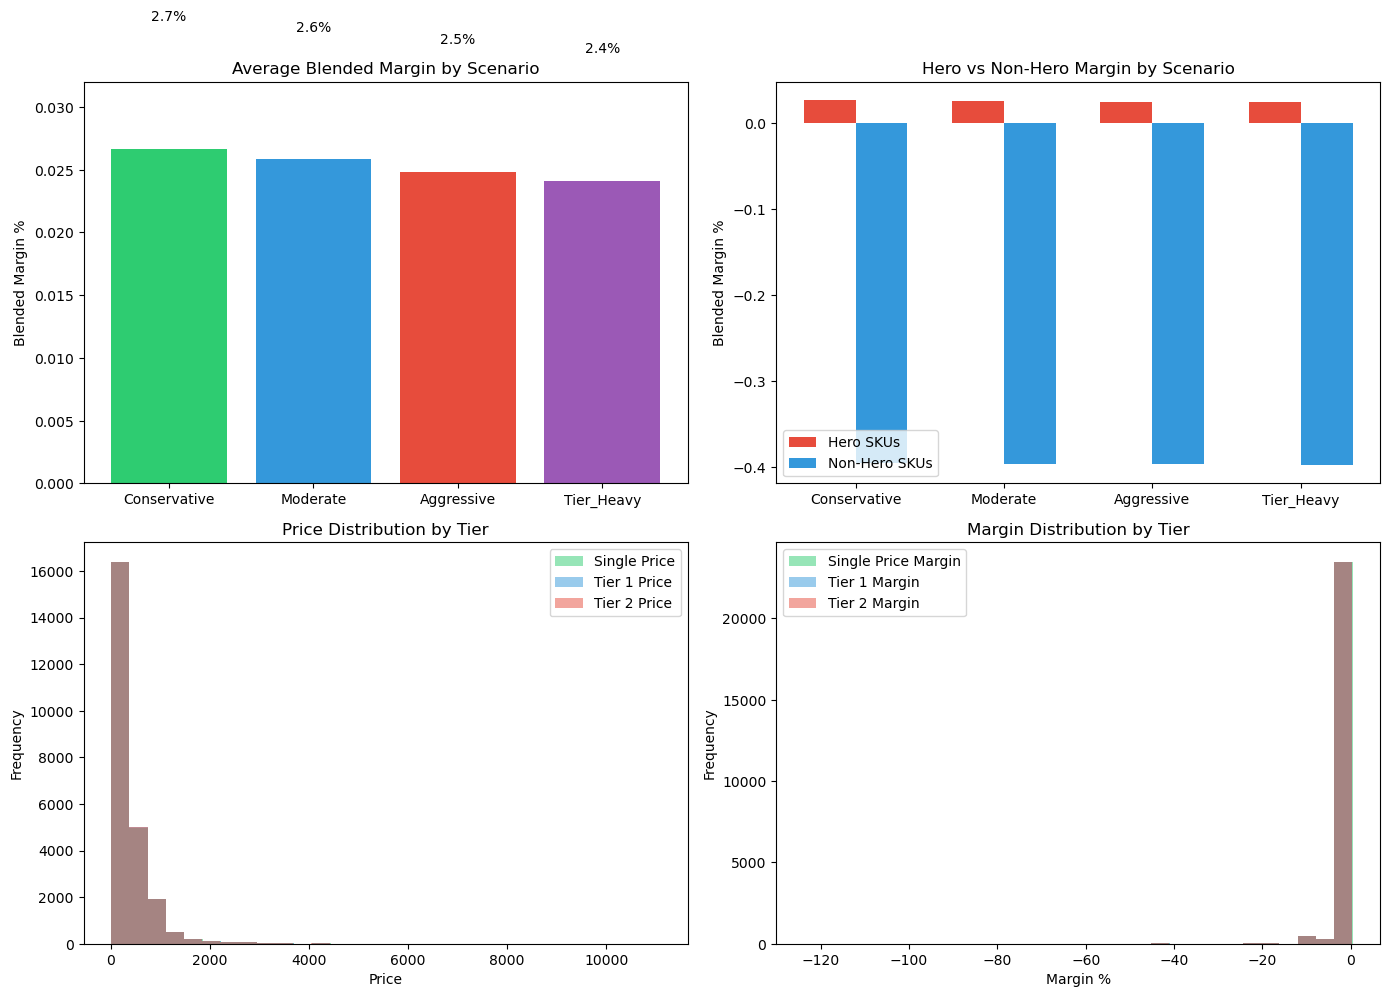


✅ Chart saved as 'pricing_scenario_analysis.png'


In [20]:
# Create visualization of scenario impacts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Blended Margin by Scenario
ax1 = axes[0, 0]
scenario_names = df_scenarios['scenario'].tolist()
margins = df_scenarios['avg_blended_margin'].tolist()
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
bars = ax1.bar(scenario_names, margins, color=colors)
ax1.set_ylabel('Blended Margin %')
ax1.set_title('Average Blended Margin by Scenario')
ax1.set_ylim(0, max(margins) * 1.2 if max(margins) > 0 else 0.5)
for bar, margin in zip(bars, margins):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{margin*100:.1f}%', ha='center', va='bottom', fontsize=10)

# 2. Hero vs Non-Hero Margin by Scenario
ax2 = axes[0, 1]
x = np.arange(len(scenario_names))
width = 0.35
hero_margins = df_scenarios['hero_avg_margin'].fillna(0).tolist()
nonhero_margins = df_scenarios['nonhero_avg_margin'].fillna(0).tolist()
ax2.bar(x - width/2, hero_margins, width, label='Hero SKUs', color='#e74c3c')
ax2.bar(x + width/2, nonhero_margins, width, label='Non-Hero SKUs', color='#3498db')
ax2.set_ylabel('Blended Margin %')
ax2.set_title('Hero vs Non-Hero Margin by Scenario')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names)
ax2.legend()

# 3. Price Distribution
ax3 = axes[1, 0]
ax3.hist(df_final['single_price'].dropna(), bins=30, alpha=0.5, label='Single Price', color='#2ecc71')
ax3.hist(df_final['tier1_price'].dropna(), bins=30, alpha=0.5, label='Tier 1 Price', color='#3498db')
ax3.hist(df_final['tier2_price'].dropna(), bins=30, alpha=0.5, label='Tier 2 Price', color='#e74c3c')
ax3.set_xlabel('Price')
ax3.set_ylabel('Frequency')
ax3.set_title('Price Distribution by Tier')
ax3.legend()

# 4. Margin Distribution
ax4 = axes[1, 1]
ax4.hist(df_final['single_price_margin'].dropna(), bins=30, alpha=0.5, label='Single Price Margin', color='#2ecc71')
ax4.hist(df_final['tier1_margin'].dropna(), bins=30, alpha=0.5, label='Tier 1 Margin', color='#3498db')
ax4.hist(df_final['tier2_margin'].dropna(), bins=30, alpha=0.5, label='Tier 2 Margin', color='#e74c3c')
ax4.set_xlabel('Margin %')
ax4.set_ylabel('Frequency')
ax4.set_title('Margin Distribution by Tier')
ax4.legend()

plt.tight_layout()
plt.savefig('pricing_scenario_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved as 'pricing_scenario_analysis.png'")

## Cell 16: Export Final Pricing Recommendations

In [21]:
# Prepare final export table - one line per SKU per cohort
export_columns = [
    'cohort_id', 'cohort_name', 'region',
    'product_id', 'sku', 'brand', 'cat',
    'packing_unit_id', 'basic_unit_count',
    'is_hero', 'order_count', 'order_contribution',
    'current_price', 'min_market_price', 'median_market_price', 'max_market_price',
    'wac1', 'wac4', 'wac_p', 'cost_per_pu',
    # Recommended prices
    'single_price', 'single_price_margin', 'price_source',
    'tier1_quantity', 'tier1_price', 'tier1_discount_pct', 'tier1_margin',
    'tier2_quantity', 'tier2_price', 'tier2_discount_pct', 'tier2_margin',
    'back_margin', 'unique_retailers'
]

# Filter and format
df_export = df_final[[col for col in export_columns if col in df_final.columns]].copy()

# Round numeric columns
price_cols = ['single_price', 'tier1_price', 'tier2_price', 'current_price', 
              'min_market_price', 'median_market_price', 'max_market_price', 'wac1', 'wac4', 'wac_p', 'cost_per_pu']
pct_cols = ['single_price_margin', 'tier1_margin', 'tier2_margin', 'tier1_discount_pct', 'tier2_discount_pct', 'back_margin']

for col in price_cols:
    if col in df_export.columns:
        df_export[col] = df_export[col].round(2)

for col in pct_cols:
    if col in df_export.columns:
        df_export[col] = (df_export[col] * 100).round(2)

# Export to CSV
df_export.to_csv('pricing_recommendations.csv', index=False)

# Export to Excel with multiple sheets
with pd.ExcelWriter('pricing_recommendations.xlsx', engine='openpyxl') as writer:
    df_export.to_excel(writer, sheet_name='All_SKUs', index=False)
    df_scenarios.to_excel(writer, sheet_name='Scenario_Analysis', index=False)
    df_cohort_summary.to_excel(writer, sheet_name='Cohort_Summary', index=False)

print(f"\n{'='*70}")
print(f"EXPORT COMPLETE")
print(f"{'='*70}")
print(f"\nExported {len(df_export)} SKU pricing recommendations")
print(f"\nFiles created:")
print(f"  - pricing_recommendations.csv")
print(f"  - pricing_recommendations.xlsx (with multiple sheets)")

df_export.head(10)


EXPORT COMPLETE

Exported 25213 SKU pricing recommendations

Files created:
  - pricing_recommendations.csv
  - pricing_recommendations.xlsx (with multiple sheets)


,cohort_id,cohort_name,region,product_id,sku,brand,cat,packing_unit_id,basic_unit_count,is_hero,order_count,order_contribution,current_price,min_market_price,median_market_price,max_market_price,wac1,wac4,wac_p,cost_per_pu,single_price,single_price_margin,price_source,tier1_quantity,tier1_price,tier1_discount_pct,tier1_margin,tier2_quantity,tier2_price,tier2_discount_pct,tier2_margin,back_margin,unique_retailers
0,700,Pricing_Model_Cairo_V2,Cairo,305,عصير بيتى مانجو - 235 مل,بيتي عصاير,عصاير,2,1.00,True,11393,0.01,204.75,NaN,NaN,NaN,203.34,185.60,185.60,185.60,204.75,9.35,Min Market (Hero),14,203.79,46.76,8.93,19,202.84,93.51,8.50,9.35,4907
1,700,Pricing_Model_Cairo_V2,Cairo,8672,ماكسى كولا - 400 مل,ماكسى,حاجه ساقعه,2,1.00,True,10727,0.01,102.50,NaN,NaN,NaN,96.00,96.00,96.00,96.00,102.50,6.34,Min Market (Hero),22,102.17,31.71,6.04,29,101.85,63.41,5.74,6.34,4252
2,700,Pricing_Model_Cairo_V2,Cairo,326,بيبسى كانز ستار - 320 مل,بيبسي,حاجه ساقعه,2,1.00,True,10347,0.01,313.75,314.00,321.00,341.25,310.35,302.33,302.33,302.33,314.00,3.72,Min Market (Hero),18,313.42,18.58,3.54,24,312.83,37.16,3.36,3.72,4241
3,700,Pricing_Model_Cairo_V2,Cairo,130,لبن بخيره - 500 مل,بخيره,ألبان,1,1.00,True,9381,0.01,491.50,NaN,NaN,NaN,503.77,475.59,475.59,475.59,491.50,3.24,Min Market (Hero),10,490.70,16.18,3.08,13,489.91,32.37,2.92,3.24,3916
4,700,Pricing_Model_Cairo_V2,Cairo,3,ارز حبوبة رفيع - 1 كجم,حبوبة,أرز,2,1.00,True,9056,0.01,241.50,236.00,257.00,266.00,235.96,231.24,231.24,231.24,236.00,2.02,Min Market (Hero),13,235.76,10.09,1.92,17,235.52,20.17,1.82,2.02,3714
5,700,Pricing_Model_Cairo_V2,Cairo,2049,كوفى بريك 2*1 - 11 جم,كوفي بريك,قهوة,3,1.00,True,9037,0.01,53.25,NaN,NaN,NaN,58.79,51.68,51.68,51.68,53.25,2.95,Min Market (Hero),20,53.17,14.76,2.81,28,53.09,29.53,2.67,2.95,3892
6,700,Pricing_Model_Cairo_V2,Cairo,205,لبن جهينة مكس شوكولاتة - 200 مل,جهينة ألبان,ألبان,2,1.00,True,8980,0.01,267.25,258.58,275.00,277.00,276.09,256.76,256.76,256.76,258.58,0.71,Min Market (Hero),8,258.49,3.53,0.67,11,258.40,7.06,0.64,0.71,3968
7,700,Pricing_Model_Cairo_V2,Cairo,6935,كوكاكولا اكشن - 300 مل,كوكا كولا,حاجه ساقعه,2,1.00,True,8803,0.01,103.00,104.50,110.00,115.95,107.00,93.00,93.00,93.00,104.50,11.00,Min Market (Hero),32,103.92,55.02,10.51,42,103.35,110.05,10.01,11.00,3575
8,700,Pricing_Model_Cairo_V2,Cairo,144,عصير بيتى كوكتيل - 235 مل,بيتي عصاير,عصاير,2,1.00,True,8294,0.01,198.00,NaN,NaN,NaN,194.83,177.71,177.71,177.71,198.00,10.25,Min Market (Hero),10,196.99,51.25,9.79,13,195.97,102.49,9.32,10.25,4004
9,700,Pricing_Model_Cairo_V2,Cairo,143,عصير بيتى تفاح - 235 مل,بيتي عصاير,عصاير,2,1.00,True,8052,0.01,198.00,NaN,NaN,NaN,201.12,184.35,184.35,184.35,198.00,6.89,Min Market (Hero),11,197.32,34.47,6.57,15,196.63,68.95,6.25,6.89,4027


## Cell 17: Summary Dashboard

In [22]:
print("\n" + "="*70)
print("PRICING STRATEGY SUMMARY DASHBOARD")
print("="*70)

print("\n📊 PORTFOLIO OVERVIEW")
print("-"*40)
print(f"Total SKUs analyzed: {len(df_final)}")
print(f"Unique products: {df_final['product_id'].nunique()}")
print(f"Hero SKUs (top 80% orders): {df_final['is_hero'].sum()} ({df_final['is_hero'].mean()*100:.1f}%)")
print(f"Non-Hero SKUs: {(~df_final['is_hero']).sum()} ({(~df_final['is_hero']).mean()*100:.1f}%)")
print(f"Cohorts covered: {df_final['cohort_id'].nunique()}")
print(f"Regions: {df_final['region'].dropna().unique().tolist()}")

print("\n💰 PRICING SUMMARY")
print("-"*40)
print(f"Average Single Price: {df_final['single_price'].mean():.2f}")
print(f"Average Tier 1 Price: {df_final['tier1_price'].mean():.2f} (Qty >= {df_final['tier1_quantity'].median():.0f})")
print(f"Average Tier 2 Price: {df_final['tier2_price'].mean():.2f} (Qty >= {df_final['tier2_quantity'].median():.0f})")

print("\n📈 MARGIN SUMMARY")
print("-"*40)
print(f"Single Price Margin: {df_final['single_price_margin'].mean()*100:.1f}%")
print(f"Tier 1 Margin: {df_final['tier1_margin'].mean()*100:.1f}%")
print(f"Tier 2 Margin: {df_final['tier2_margin'].mean()*100:.1f}%")
print(f"Back Margin (WAC4): {df_final['back_margin'].mean()*100:.1f}%")

print("\n🎯 RECOMMENDED SCENARIO")
print("-"*40)
best_scenario = df_scenarios.loc[df_scenarios['total_estimated_gp'].idxmax()]
print(f"Highest GP Scenario: {best_scenario['scenario']}")
print(f"  - Single: {best_scenario['single_pct']*100:.0f}%, T1: {best_scenario['tier1_pct']*100:.0f}%, T2: {best_scenario['tier2_pct']*100:.0f}%")
print(f"  - Estimated GP: {best_scenario['total_estimated_gp']:,.0f}")

print("\n⚠️ ALERTS")
print("-"*40)
below_cost = df_final['tier2_below_cost'].sum()
if below_cost > 0:
    print(f"⚠️ {below_cost} SKUs have Tier 2 price below WAC - review these!")
else:
    print("✅ All tier prices are above WAC")

print("\n" + "="*70)


PRICING STRATEGY SUMMARY DASHBOARD

📊 PORTFOLIO OVERVIEW
----------------------------------------
Total SKUs analyzed: 25213
Unique products: 3404
Hero SKUs (top 80% orders): 761 (3.0%)
Non-Hero SKUs: 24452 (97.0%)
Cohorts covered: 9
Regions: ['Cairo', 'Giza', 'Alexandria', 'Delta West', 'Delta East', 'Upper Egypt']

💰 PRICING SUMMARY
----------------------------------------
Average Single Price: 363.56
Average Tier 1 Price: 362.50 (Qty >= 3)
Average Tier 2 Price: 361.43 (Qty >= 4)

📈 MARGIN SUMMARY
----------------------------------------
Single Price Margin: -38.1%
Tier 1 Margin: -38.4%
Tier 2 Margin: -38.6%
Back Margin (WAC4): -38.1%

🎯 RECOMMENDED SCENARIO
----------------------------------------
Highest GP Scenario: Conservative
  - Single: 70%, T1: 20%, T2: 10%
  - Estimated GP: 21,974,766

⚠️ ALERTS
----------------------------------------
⚠️ 1619 SKUs have Tier 2 price below WAC - review these!



## Cell 18: Generate Upload Format for Quantity Discounts

In [23]:
# Tag mapping for regions
Tag_def = {
    'region': ['Cairo', 'Giza', 'Alexandria', 'Upper Egypt', 'Delta East', 'Delta West'],
    'Tag ID': [2807, 2808, 2809, 2810, 2811, 2812]
}
Tag_map = pd.DataFrame(Tag_def)

# Cohort to region mapping
cohort_region_map = {
    700: 'Cairo',
    701: 'Giza', 
    702: 'Alexandria',
    703: 'Delta West',
    704: 'Delta East',
    1123: 'Upper Egypt',
    1124: 'Upper Egypt',
    1125: 'Upper Egypt',
    1126: 'Upper Egypt'
}

# Prepare QD upload format
final_quantity_discount = pd.DataFrame(columns=['region', 'Discounts Group 1', 'Discounts Group 2', 'Description'])

for cohort_id in df_final['cohort_id'].unique():
    cohort_data = df_final[df_final['cohort_id'] == cohort_id]
    region = cohort_region_map.get(cohort_id, 'Unknown')
    
    for i, r in cohort_data.iterrows():
        product_id = int(r['product_id'])
        packing_unit_id = int(r['packing_unit_id'])
        q_1 = int(r['tier1_quantity'])
        q_2 = int(r['tier2_quantity'])
        d_1 = round(r['tier1_discount_pct'], 2)
        d_2 = round(r['tier2_discount_pct'], 2)
        
        a_1 = [product_id, packing_unit_id, q_1, d_1]
        a_2 = [product_id, packing_unit_id, q_2, d_2]
        
        new_row = {
            'region': region,
            'Discounts Group 1': a_1,
            'Discounts Group 2': a_2,
            'Description': f'{region}QD'
        }
        new_row_df = pd.DataFrame([new_row])
        final_quantity_discount = pd.concat([final_quantity_discount, new_row_df], ignore_index=True)

# Add Tag IDs and dates
final_quantity_discount = final_quantity_discount.merge(Tag_map, on='region')

# Set start and end dates
local_tz = pytz.timezone('Africa/Cairo')
today = datetime.now(local_tz)
start_date = (today + timedelta(minutes=15)).strftime('%d/%m/%Y %H:%M')
end_date = (today + timedelta(days=1)).replace(hour=23, minute=59).strftime('%d/%m/%Y %H:%M')

final_quantity_discount['Start Date/Time'] = start_date
final_quantity_discount['End Date/Time'] = end_date

# Group by Tag ID for final upload format
final_data = final_quantity_discount.groupby(['Tag ID', 'Description', 'Start Date/Time', 'End Date/Time'], as_index=False).agg({
    'Discounts Group 1': list,
    'Discounts Group 2': list
})

# Save to Excel
final_data.to_excel('QD_upload.xlsx', index=False)

print(f"\n{'='*70}")
print(f"QD UPLOAD FILE GENERATED")
print(f"{'='*70}")
print(f"\nFile saved: QD_upload.xlsx")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"\nRegions/Tags included:")
print(final_data[['Tag ID', 'Description']].to_string(index=False))

final_data.head()


QD UPLOAD FILE GENERATED

File saved: QD_upload.xlsx
Start Date: 27/11/2025 13:25
End Date: 28/11/2025 23:59

Regions/Tags included:
 Tag ID   Description
   2807       CairoQD
   2808        GizaQD
   2809  AlexandriaQD
   2810 Upper EgyptQD
   2811  Delta EastQD
   2812  Delta WestQD


,Tag ID,Description,Start Date/Time,End Date/Time,Discounts Group 1,Discounts Group 2
0,2807,CairoQD,27/11/2025 13:25,28/11/2025 23:59,"[[305, 2, 14, 0.47], [8672, 2, 22, 0.32], [326...","[[305, 2, 19, 0.94], [8672, 2, 29, 0.63], [326..."
1,2808,GizaQD,27/11/2025 13:25,28/11/2025 23:59,"[[326, 2, 16, 0.18], [130, 1, 10, 0.16], [2049...","[[326, 2, 21, 0.36], [130, 1, 13, 0.33], [2049..."
2,2809,AlexandriaQD,27/11/2025 13:25,28/11/2025 23:59,"[[6935, 2, 32, 0.64], [8648, 2, 15, 0.42], [36...","[[6935, 2, 42, 1.29], [8648, 2, 20, 0.83], [36..."
3,2810,Upper EgyptQD,27/11/2025 13:25,28/11/2025 23:59,"[[305, 2, 14, 0.32], [130, 1, 9, 0.16], [6935,...","[[305, 2, 19, 0.65], [130, 1, 12, 0.33], [6935..."
4,2811,Delta EastQD,27/11/2025 13:25,28/11/2025 23:59,"[[6935, 2, 24, 0.65], [130, 1, 6, 0.17], [305,...","[[6935, 2, 33, 1.31], [130, 1, 8, 0.33], [305,..."
